In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import DiadFit as pf
import seaborn as sns 
import Thermobar as pt
import CoolProp.CoolProp as CP
from scipy.optimize import fsolve

In [2]:
# Load fluid inclusion microthermometry data
FI = pd.read_excel('Data/FluidInclusions_final.xlsx')
FI.head()

,Sample,"Homogenized_to (V for vapor, L for liquid)",Primary (P) or Secondary (S),Th_low (oC),Th_high (oC),Tm_low (oC),Tm_high (oC),Mean_CO2dens (gcm3),Max_CO2dens (gcm3),Min_CO2dens (gcm3),rhoCO2_He (g/cm3),rhoCO2_Ar (g/cm3),CO2_dens_raman (g/cc),sigma_CO2_dens_raman (g/cc),LaserPower (mW)
0,04b_pyx3_FI1,L,P,-14.752128,-14.651773,-56.600000,-56.499645,1.006508,1.007241,1.005774,1.006530,1.006530,0.997311,0.001730,6.0
1,04b_pyx3_FI2,L,P,-14.752128,-14.651773,-56.700355,-56.600000,1.006508,1.007241,1.005774,1.006724,1.006449,1.001248,0.008216,6.0
2,04b_pyx3_FI3,L,P,-16.458156,-16.357801,-57.101773,-57.001418,1.014762,1.015481,1.014042,1.017415,1.013952,0.986997,0.002231,6.0
3,04b_pyx3_FI4,L,P,-14.952837,-14.852482,-56.600000,-56.499645,1.007487,1.008218,1.006755,1.007508,1.007508,1.002131,0.002034,6.0
4,04b_pyx1_FI1,L,P,-17.060284,-16.959929,-57.904610,-57.703901,1.017639,1.018354,1.016923,1.026406,1.015534,1.006379,0.001732,6.0


# Solve for pressure assuming each sample is pure CO2


In [3]:
# Set up DataFrame for Monte Carlo sampling
Results = pd.DataFrame(data = np.zeros((1000*len(FI['Mean_CO2dens (gcm3)']),3)), 
                       columns = ['Sample', 'T_C', 'CO2_density'])

Results['Sample'] = [None]*len(Results['Sample'])
CO2 = np.array([])
for i in range(len(FI['Mean_CO2dens (gcm3)'])):
    A = np.random.random(1000)
    if '03b' in FI['Sample'].loc[i]:
        Results.loc[i*1000:1000+i*1000,'Sample'] = "03b"
    else:
        Results.loc[i*1000:1000+i*1000,'Sample'] = "04b"

    CO2_new = FI['Min_CO2dens (gcm3)'].loc[i] + A*(FI['Max_CO2dens (gcm3)'].loc[i] - FI['Min_CO2dens (gcm3)'].loc[i]) 
    CO2 = np.concatenate([CO2, CO2_new])

Results['CO2_density'] = CO2


In [4]:
T_03b = pd.read_excel('T_03b.xlsx')
T_04b = pd.read_excel('T_04b.xlsx')

In [5]:
# extract temperatures from cpx-opx barometry
T1 = T_03b['T_K_calc'].sample(len(Results[Results['Sample'] == "03b"]), replace=True).values - 273.15
T2 = T_04b['T_K_calc'].sample(len(Results[Results['Sample'] == "04b"]), replace=True).values - 273.15
T = np.concatenate([T2,T1])

Results['T_C'] = T

In [6]:
# Now convert these CO2 densities into entrapment pressures
Results['P_MPa'] = pf.calculate_P_for_rho_T(CO2_dens_gcm3=Results['CO2_density'], T_K=Results['T_C']+273.15, EOS='SW96')['P_MPa']

In [7]:
# Extract the mean and std for plotting
BasicOutput = pd.DataFrame(columns = ['Sample', 'P_MPa_mean', 'P_MPa_median', 'P_MPa_std', 'T_C_mean', 'T_C_median', 'T_C_std'])
BasicOutput['Sample'] = FI['Sample']

for i in range(len(BasicOutput['Sample'])):
    BasicOutput.loc[i,'P_MPa_mean'] = np.nanmean(Results['P_MPa'].loc[i*1000:100 + i*1000])
    BasicOutput.loc[i,'P_MPa_median'] = np.nanmedian(Results['P_MPa'].loc[i*1000:100 + i*1000])
    BasicOutput.loc[i,'P_MPa_std'] = np.nanstd(Results['P_MPa'].loc[i*1000:100 + i*1000])

    BasicOutput.loc[i,'T_C_mean'] = np.nanmean(Results['T_C'].loc[i*1000:100 + i*1000])
    BasicOutput.loc[i,'T_C_median'] = np.nanmedian(Results['T_C'].loc[i*1000:100 + i*1000])
    BasicOutput.loc[i,'T_C_std'] = np.nanstd(Results['T_C'].loc[i*1000:100 + i*1000])

/var/folders/vm/7v8p43js2918h18x32py6b9r0000gn/T/ipykernel_21023/2091456921.py:6: RuntimeWarning: Mean of empty slice
  BasicOutput.loc[i,'P_MPa_mean'] = np.nanmean(Results['P_MPa'].loc[i*1000:100 + i*1000])
/Users/gleesonm/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/gleesonm/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vm/7v8p43js2918h18x32py6b9r0000gn/T/ipykernel_21023/2091456921.py:6: RuntimeWarning: Mean of empty slice
  BasicOutput.loc[i,'P_MPa_mean'] = np.nanmean(Results['P_MPa'].loc[i*1000:100 + i*1000])
/Users/gleesonm/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, kee

# Work out the influence of H2O on these pressure calculations

In [8]:
# First use PetThermoTools and rhyolite-MELTS v1.2.0 to determine the max XH2O in this system
bulk = {'SiO2_Liq': 48.12,
        'TiO2_Liq': 2.09,
        'Al2O3_Liq': 16.44,
        'FeOt_Liq': 9.40,
        'MnO_Liq': 0.18,
        'MgO_Liq': 6.50,
        'CaO_Liq': 11.91,
        'Na2O_Liq': 3.76,
        'K2O_Liq': 1.05,
        'P2O5_Liq': 0.30,
        'Fe3Fet_Liq': 0.10}

In [11]:
import PetThermoTools as ptt 
import sys
sys.path.append(r'/Users/gleesonm/Library/CloudStorage/GoogleDrive-gleesonm@berkeley.edu/My Drive/2022/GitHub/MELTS130beta/MacOS')

In [13]:
# Can be used to suppress outputs on MacOS - run twice
import os
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

In [14]:
# Using assumed CO2 and H2O contents find the approx pressure of fluid saturation
Sat = ptt.findSatPressure(Model = "MELTSv1.2.0", bulk = bulk, T_C_init = 1200, 
                              P_bar_init = 7500, H2O_Liq = np.array([0.55, 0.55, 2, 2]), 
                              CO2_Liq = np.array([0.5,0.8,0.5,0.8000]), 
                              fO2_buffer = "FMQ")

In [13]:
# Equilibrate the system at 10 bars lower pressure to force a fluid phase to be present.
Out = ptt.equilibrate_multi(Model = "MELTSv1.2.0", bulk = Sat, P_bar = Sat['P_bar'].values - 10, T_C = Sat['T_Liq'].values - 1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
Out['X_H2O_mol_fluid1']

0    0.015688
1    0.013105
2    0.148104
3    0.120298
Name: X_H2O_mol_fluid1, dtype: float64

In [17]:
# Use the composition of the fluid phase to estimate the XH2O.
# XH2O = np.zeros(4)
# j = 0
# for i in Out:
#     XH2O[j] = (Out[i]['fluid1']['H2O']/18)/(Out[i]['fluid1']['H2O']/18 + Out[i]['fluid1']['CO2']/44.04)
#     j = j + 1

XH2O = Out['X_H2O_mol_fluid1'].values

np.sort(XH2O)

array([0.01310493, 0.01568848, 0.12029818, 0.14810393])

In [9]:
# Max XH2O content is 0.15. Use this, with the calculations above to estimate the equilibration pressure of the Isla Floreana fluid inclusions.
Results['P_MPa_H2O'] = pf.calculate_entrapment_P_XH2O(XH2O = 0.15,
                               CO2_dens_gcm3 = Results['CO2_density'],
                               T_K = Results['T_C'] + 273.15,
                               )['P_kbar_mixCO2_DZ06_no_Hloss']*100

In [10]:
# add mean/std to main dataframe
BasicOutput['P_MPa_H2O_mean'] = np.zeros(len(BasicOutput['Sample']))
BasicOutput['P_MPa_H2O_median'] = np.zeros(len(BasicOutput['Sample']))
BasicOutput['P_MPa_H2O_std'] = np.zeros(len(BasicOutput['Sample']))

for i in range(len(BasicOutput['Sample'])):
    BasicOutput.loc[i,'P_MPa_H2O_mean'] = np.nanmean(Results['P_MPa_H2O'].loc[i*1000:100 + i*1000])
    BasicOutput.loc[i,'P_MPa_H2O_median'] = np.nanmean(Results['P_MPa_H2O'].loc[i*1000:100 + i*1000])
    BasicOutput.loc[i,'P_MPa_H2O_std'] = np.nanstd(Results['P_MPa_H2O'].loc[i*1000:100 + i*1000])

/var/folders/vm/7v8p43js2918h18x32py6b9r0000gn/T/ipykernel_97664/3505484572.py:7: RuntimeWarning: Mean of empty slice
  BasicOutput.loc[i,'P_MPa_H2O_mean'] = np.nanmean(Results['P_MPa_H2O'].loc[i*1000:100 + i*1000])
/var/folders/vm/7v8p43js2918h18x32py6b9r0000gn/T/ipykernel_97664/3505484572.py:8: RuntimeWarning: Mean of empty slice
  BasicOutput.loc[i,'P_MPa_H2O_median'] = np.nanmean(Results['P_MPa_H2O'].loc[i*1000:100 + i*1000])
/Users/gleesonm/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vm/7v8p43js2918h18x32py6b9r0000gn/T/ipykernel_97664/3505484572.py:7: RuntimeWarning: Mean of empty slice
  BasicOutput.loc[i,'P_MPa_H2O_mean'] = np.nanmean(Results['P_MPa_H2O'].loc[i*1000:100 + i*1000])
/var/folders/vm/7v8p43js2918h18x32py6b9r0000gn/T/ipykernel_97664/3505484572.py:8: RuntimeWarning: Mean of empty slice
  BasicOutput.loc[i,'P_MPa_H2O_m

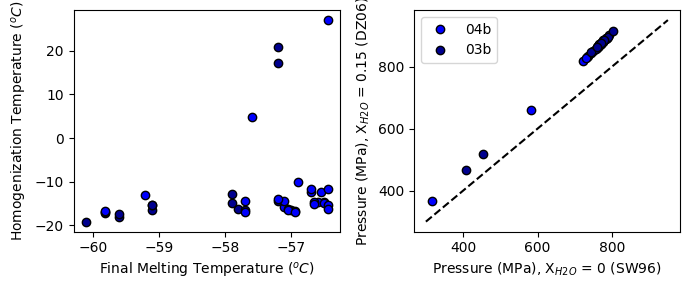

In [11]:
f, a = plt.subplots(1,2, figsize = (7, 3))
a[0].plot(FI['Tm_high (oC)'][FI['Sample'].str.contains('03b')],
       (FI['Th_high (oC)'][FI['Sample'].str.contains('03b')]+FI['Th_low (oC)'][FI['Sample'].str.contains('03b')])/2, 'ok', mfc = (0,0,0.56), label = "03b")
a[0].plot(FI['Tm_high (oC)'][FI['Sample'].str.contains('04b')],
       (FI['Th_high (oC)'][FI['Sample'].str.contains('04b')]+FI['Th_low (oC)'][FI['Sample'].str.contains('04b')])/2, 'ok', mfc = 'b', label = "04b")

a[0].set_xlabel('Final Melting Temperature ($^oC$)')
a[0].set_ylabel('Homogenization Temperature ($^oC$)')

a[1].plot(BasicOutput['P_MPa_mean'][BasicOutput['Sample'].str.contains('04b')],
       BasicOutput['P_MPa_H2O_mean'][BasicOutput['Sample'].str.contains('04b')],
       mfc = (0,0,1), mec = 'k', linestyle = 'none', marker = 'o', label = '04b')
a[1].plot(BasicOutput['P_MPa_median'][BasicOutput['Sample'].str.contains('03b')],
       BasicOutput['P_MPa_H2O_median'][BasicOutput['Sample'].str.contains('03b')],
       'ok', mfc = (0,0,0.56), label = '03b')

a[1].plot([300,950],[300,950], '--k')
# a[1].plot([400,950],1.15*np.array([400,950]), ':r')
a[1].set_xlabel('Pressure (MPa), X$_{H2O}$ = 0 (SW96)')
a[1].set_ylabel('Pressure (MPa), X$_{H2O}$ = 0.15 (DZ06)')

a[1].legend()
f.tight_layout()

plt.savefig('Fig11.svg', dpi = 600, format = 'svg')

# Influence of He

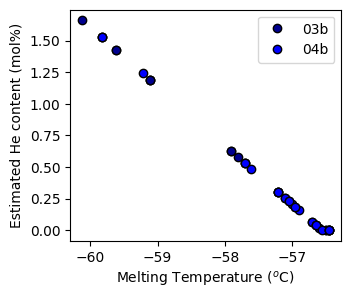

In [15]:
# assuming CO2-He fluids, use coolprop and the melting temperatures to estimate the potential He mol%
HEOS = CP.AbstractState('HEOS', 'Helium&CarbonDioxide')
T = np.zeros(100)
x0 = np.linspace(0.00000001,0.05,100)
for i in range(len(x0)):
    HEOS.set_mole_fractions([x0[i], 1 - x0[i]])
    T[i] = HEOS.Ttriple()

p = np.polyfit((x0)*100, T-273.15, 1)
He_ = (FI['Tm_high (oC)']-p[1])/(p[0])
He_[np.where(He_< 0.0)] = 0.0000001

f, a = plt.subplots(1,1, figsize = (3.5,3))
a.plot(FI.loc[FI['Sample'].str.contains('03b'),'Tm_high (oC)'],
       He_[np.where(FI['Sample'].str.contains('03b'))[0]], 'ok', mfc = (0,0,0.56), label = "03b")
a.plot(FI.loc[FI['Sample'].str.contains('04b'),'Tm_high (oC)'],
       He_[np.where(FI['Sample'].str.contains('04b'))[0]], 'ok', mfc = (0,0,1), label = "04b")

a.set_xlabel('Melting Temperature ($^o$C)')
a.set_ylabel('Estimated He content (mol%)')
a.legend()

In [16]:
# Define the helium mole fractions you want to analyze
helium_mole_fractions = He_.values/100

# Define the homogenization temperature (in Kelvin)
homogenization_temperature = (FI['Th_high (oC)'].values + 
                            FI['Th_low (oC)'].values)/2 + 273.15  # Example temperature in Kelvin

# Array to store the densities
densities = np.zeros(len(helium_mole_fractions))
ratio = np.zeros(len(helium_mole_fractions))

for i, x_He in enumerate(helium_mole_fractions):
    # Set the mole fractions of the mixture
    x_CO2 = 1 - x_He
    HEOS.set_mole_fractions([x_He, x_CO2])

    if (homogenization_temperature[i] > -30 + 273.15) & (homogenization_temperature[i] < 30 + 273.15):
        # Set the temperature to the homogenization temperature
        HEOS.update(CP.QT_INPUTS, 0, homogenization_temperature[i])  # Q=0 means saturated liquid

        # Get the density at the specified temperature and pressure
        densities[i] = HEOS.rhomass()

FI['rhoCO2_He'] = densities/1000

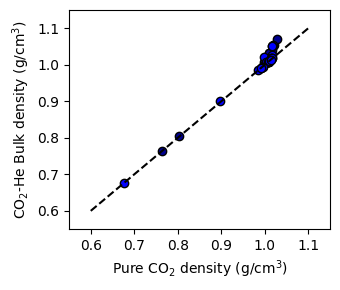

In [17]:
f, a = plt.subplots(1,1, figsize = (3.5,3))
a.plot(FI.loc[FI['Sample'].str.contains('03b'),'Mean_CO2dens (gcm3)'],
       FI.loc[FI['Sample'].str.contains('03b'),'rhoCO2_He'], 'ok', mfc = (0,0,0.56), label = "03b")
a.plot(FI.loc[FI['Sample'].str.contains('04b'),'Mean_CO2dens (gcm3)'],
       FI.loc[FI['Sample'].str.contains('04b'),'rhoCO2_He'], 'ok', mfc = 'b', label = "04b")

a.plot([0.6,1.1], [0.6, 1.1], '--k')
a.set_xlabel('Pure CO$_2$ density (g/cm$^3$)')
a.set_ylabel('CO$_2$-He Bulk density (g/cm$^3$)')
a.set_ylim([0.55,1.15])
a.set_xlim([0.55,1.15])

f.tight_layout()

# Now do the same for Argon

Text(0, 0.5, 'Estimated Ar content (mol%)')

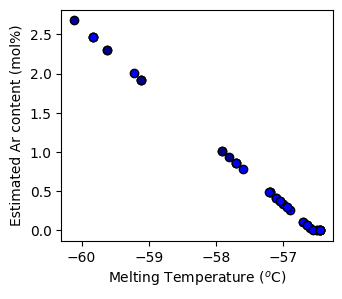

In [18]:
# assuming CO2-He fluids, use coolprop and the melting temperatures to estimate the potential He mol%
HEOS = CP.AbstractState('HEOS', 'Argon&CarbonDioxide')
T = np.zeros(100)
x0 = np.linspace(0.00000001,0.05,100)
for i in range(len(x0)):
    HEOS.set_mole_fractions([x0[i], 1 - x0[i]])
    T[i] = HEOS.Ttriple()

p = np.polyfit((x0)*100, T-273.15, 1)
Ar_ = (FI['Tm_high (oC)']-p[1])/(p[0])
Ar_[np.where(Ar_< 0.0)] = 0.0000001

f, a = plt.subplots(1,1, figsize = (3.5,3))
a.plot(FI.loc[FI['Sample'].str.contains('03b'),'Tm_high (oC)'],
       Ar_[np.where(FI['Sample'].str.contains('03b'))[0]], 'ok', mfc = (0,0,0.56), label = "03b")
a.plot(FI.loc[FI['Sample'].str.contains('04b'),'Tm_high (oC)'],
       Ar_[np.where(FI['Sample'].str.contains('04b'))[0]], 'ok', mfc = (0,0,1), label = "04b")

a.set_xlabel('Melting Temperature ($^o$C)')
a.set_ylabel('Estimated Ar content (mol%)')
# a.legend()

In [19]:
# Define the helium mole fractions you want to analyze
argon_mole_fractions = He_.values/100

# Define the homogenization temperature (in Kelvin)
homogenization_temperature = (FI['Th_high (oC)'].values + 
                            FI['Th_low (oC)'].values)/2 + 273.15  # Example temperature in Kelvin

# Array to store the densities
densities = np.zeros(len(argon_mole_fractions))
ratio = np.zeros(len(argon_mole_fractions))

for i, x_Ar in enumerate(argon_mole_fractions):
    # Set the mole fractions of the mixture
    x_CO2 = 1 - x_Ar
    HEOS.set_mole_fractions([x_Ar, x_CO2])

    if (homogenization_temperature[i] > -30 + 273.15) & (homogenization_temperature[i] < 30 + 273.15):
        # Set the temperature to the homogenization temperature
        HEOS.update(CP.QT_INPUTS, 0, homogenization_temperature[i])  # Q=0 means saturated liquid

        # Get the density at the specified temperature and pressure
        densities[i] = HEOS.rhomass()

FI['rhoCO2_Ar'] = densities/1000

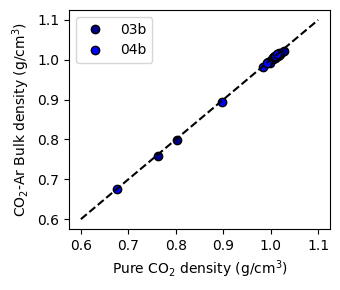

In [20]:
f, a = plt.subplots(1,1, figsize = (3.5,3))
a.plot(FI.loc[FI['Sample'].str.contains('03b'),'Mean_CO2dens (gcm3)'],
       FI.loc[FI['Sample'].str.contains('03b'),'rhoCO2_Ar'], 'ok', mfc = (0,0,0.56), label = "03b")
a.plot(FI.loc[FI['Sample'].str.contains('04b'),'Mean_CO2dens (gcm3)'],
       FI.loc[FI['Sample'].str.contains('04b'),'rhoCO2_Ar'], 'ok', mfc = 'b', label = "04b")

a.plot([0.6,1.1], [0.6, 1.1], '--k')
a.set_xlabel('Pure CO$_2$ density (g/cm$^3$)')
a.set_ylabel('CO$_2$-Ar Bulk density (g/cm$^3$)')
a.legend()

f.tight_layout()

# now add in calculation plotting isochores for different He or Ar mole fractions


In [22]:
from scipy.optimize import fsolve

HEOS = CP.AbstractState('HEOS', 'Helium&CarbonDioxide')
T = np.linspace(-17, 1000, 2001)
x0 = np.array([0,0.005,0.01,0.015,0.02])
P_solve = np.zeros((len(x0), len(T)))

In [23]:
# Define the homogenization temperature (in Kelvin)
homogenization_temperature = -17.0 + 273.15  # Example temperature in Kelvin

# Array to store the densities
densities = np.zeros(len(x0))

for i, x_He in enumerate(x0):
    # Set the mole fractions of the mixture
    x_CO2 = 1 - x_He
    HEOS.set_mole_fractions([x_He, x_CO2])

    # Set the temperature to the homogenization temperature
    HEOS.update(CP.QT_INPUTS, 0, homogenization_temperature)  # Q=0 means saturated liquid

    # Get the density at the specified temperature and pressure
    densities[i] = HEOS.rhomass()

In [24]:
def find_pressure_for_density_CO2(pressure, target_density, temperature, x_CO2, x_He):
    try:
        HEOS.set_mole_fractions([x_He, x_CO2])
        HEOS.update(CP.PT_INPUTS, pressure, temperature)
        return HEOS.rhomass() - target_density
    except ValueError as e:
        print(f"Error encountered at pressure {pressure}: {e}")
        return np.inf  # Return a large number to indicate failure

P_initial = np.zeros(len(T))
for j in range(len(T)):
    for i, x_He in enumerate(x0):
        # Set the mole fractions of the mixture
        # try:
        x_CO2 = 1 - x_He
        target_density = densities[i]

        initial_pressure_guess = pf.calculate_P_for_rho_T(CO2_dens_gcm3=densities[0]/1000, T_K=T[j]+273.15, EOS='SW96')['P_MPa'].values*1000000
        P_initial[j] = initial_pressure_guess

        P_solve[i,j] = fsolve(find_pressure_for_density_CO2, initial_pressure_guess, args=(target_density, T[j] + 273.15, x_CO2, x_He))[0]

# T[np.where(P_solve[0,:] == P_initial)] = np.nan

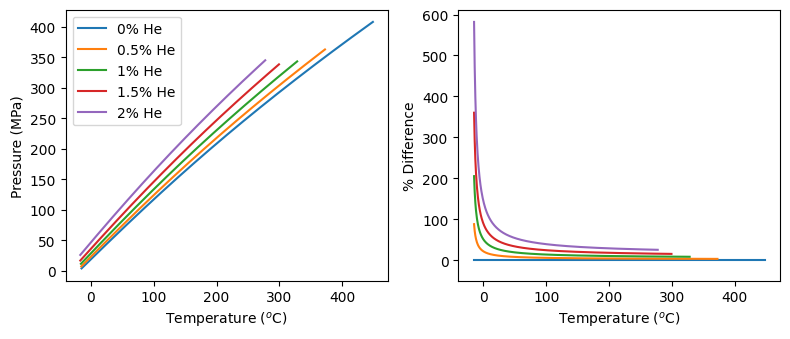

In [25]:
for i in range(len(densities)):
    P_solve[i,np.where(P_solve[i,:] == P_initial)[0]] = np.nan
    
f, a = plt.subplots(1,2, figsize = (8,3.5))
a[0].plot(T, P_solve.T/(10**6))
a[0].set_ylabel('Pressure (MPa)')
a[0].set_xlabel('Temperature ($^o$C)')

a[1].plot(T, 100*((P_solve.T - P_solve[0,:].reshape((2001,1)))/P_solve[0,:].reshape((2001,1))))
a[1].set_ylabel('% Difference')
a[1].set_xlabel('Temperature ($^o$C)')

a[0].legend(['0% He', '0.5% He', '1% He', '1.5% He', '2% He'])
f.tight_layout()

# Same calculations but for Ar


In [26]:
HEOS = CP.AbstractState('HEOS', 'Argon&CarbonDioxide')
T = np.linspace(-17, 1000, 2001)
x0 = np.array([0,0.005,0.01,0.015,0.02])
P_solve = np.zeros((len(x0), len(T)))

In [27]:
# Define the homogenization temperature (in Kelvin)
homogenization_temperature = -17.0 + 273.15  # Example temperature in Kelvin

# Array to store the densities
densities = np.zeros(len(x0))

for i, x_Ar in enumerate(x0):
    # Set the mole fractions of the mixture
    x_CO2 = 1 - x_Ar
    HEOS.set_mole_fractions([x_Ar, x_CO2])

    # Set the temperature to the homogenization temperature
    HEOS.update(CP.QT_INPUTS, 0, homogenization_temperature)  # Q=0 means saturated liquid

    # Get the density at the specified temperature and pressure
    densities[i] = HEOS.rhomass()

In [28]:
def find_pressure_for_density_CO2(pressure, target_density, temperature, x_CO2, x_Ar):
    try:
        HEOS.set_mole_fractions([x_Ar, x_CO2])
        HEOS.update(CP.PT_INPUTS, pressure, temperature)
        return HEOS.rhomass() - target_density
    except ValueError as e:
        print(f"Error encountered at pressure {pressure}: {e}")
        return np.inf  # Return a large number to indicate failure

P_initial = np.zeros(len(T))
for j in range(len(T)):
    for i, x_Ar in enumerate(x0):
        # Set the mole fractions of the mixture
        # try:
        x_CO2 = 1 - x_Ar
        target_density = densities[i]

        initial_pressure_guess = pf.calculate_P_for_rho_T(CO2_dens_gcm3=densities[0]/1000, T_K=T[j]+273.15, EOS='SW96')['P_MPa'].values*1000000
        P_initial[j] = initial_pressure_guess

        P_solve[i,j] = fsolve(find_pressure_for_density_CO2, initial_pressure_guess, args=(target_density, T[j] + 273.15, x_CO2, x_Ar))[0]



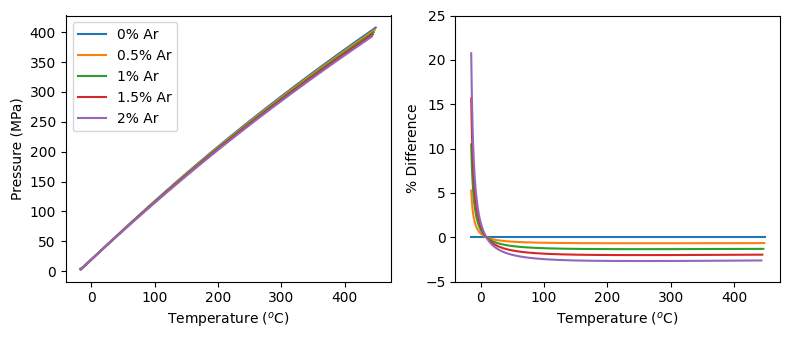

In [29]:
for i in range(len(densities)):
    P_solve[i,np.where(P_solve[i,:] == P_initial)[0]] = np.nan
    
f, a = plt.subplots(1,2, figsize = (8,3.5))
a[0].plot(T, P_solve.T/(10**6))
a[0].set_ylabel('Pressure (MPa)')
a[0].set_xlabel('Temperature ($^o$C)')

a[1].plot(T, 100*((P_solve.T - P_solve[0,:].reshape((2001,1)))/P_solve[0,:].reshape((2001,1))))
a[1].set_ylabel('% Difference')
a[1].set_xlabel('Temperature ($^o$C)')

a[0].legend(['0% Ar', '0.5% Ar', '1% Ar', '1.5% Ar', '2% Ar'])
a[1].set_ylim([-5,25])
f.tight_layout()

# Raman vs Microthermometry CO2 densities

In [30]:
FI_03b = FI.loc[FI['Sample'].str.contains('03b')].copy()
FI_04b = FI.loc[FI['Sample'].str.contains('04b')].copy()


Text(0.5, 0, 'CO$_2$ density (Microthermometry)')

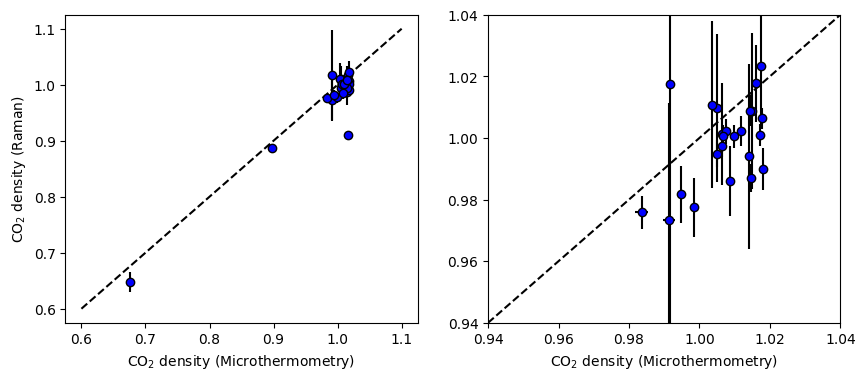

In [31]:
f, a = plt.subplots(1,2, figsize = (10,4))
a[0].errorbar(FI_04b['Mean_CO2dens (gcm3)'], FI_04b['CO2_dens_raman (g/cc)'], xerr = FI_04b['Mean_CO2dens (gcm3)'] - FI_04b['Min_CO2dens (gcm3)'],
            yerr = 2*FI_04b['sigma_CO2_dens_raman (g/cc)'], marker = 'o', linestyle = 'none', mfc = 'b', mec = 'k', ecolor = 'k')
a[0].plot([0.6,1.1],[0.6,1.1], '--k')
# a.scatter(FI['Mean_CO2dens (gcm3)'], FI['CO2_dens_raman (g/cc)'], c = FI['Tm_high (oC)'], s = 20)

a[1].errorbar(FI_04b['Mean_CO2dens (gcm3)'], FI_04b['CO2_dens_raman (g/cc)'], xerr = FI_04b['Mean_CO2dens (gcm3)'] - FI_04b['Min_CO2dens (gcm3)'],
            yerr = 2*FI_04b['sigma_CO2_dens_raman (g/cc)'], marker = 'o', linestyle = 'none', mfc = 'b', mec = 'k', ecolor = 'k')
a[1].plot([0.6,1.1],[0.6,1.1], '--k')
a[1].set_ylim([0.94,1.04])
a[1].set_xlim([0.94,1.04])

a[0].set_ylabel('CO$_2$ density (Raman)')
a[0].set_xlabel('CO$_2$ density (Microthermometry)')

a[1].set_xlabel('CO$_2$ density (Microthermometry)')